In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage import io, feature, filters, transform, measure
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt
from skimage.measure import label
from skimage.segmentation import watershed
from skimage.measure import find_contours
from scipy import ndimage as ndi
# from utils import *

In [2]:
# def compute_largest_eigenvalue(image, sigma=1, pad_width=10):
#     nuclear = (image!=0).astype(np.uint8)
#     nuclear_scaled = transform.rescale(nuclear, (500-pad_width*2)/500)
#     nuclear_padded = np.pad(nuclear_scaled, pad_width=pad_width, mode='constant', constant_values=0)

#     # 计算结构张量
#     result = feature.structure_tensor(image, sigma=sigma, order='rc')
#     # 从结构张量中获取特征值
#     eigenvalues = feature.structure_tensor_eigenvalues(result)
#     # 返回每个点的最大特征值
#     return np.max(eigenvalues, axis=0)*nuclear_padded

# # 使用distance_transform_edt
# def apply_h_watershed(image, min_distance=5):
#     mask = image > threshold_otsu(image[image>0])
#     # 计算距离变换
#     distance = distance_transform_edt(mask)
#     # 在距离图中找到峰值
#     local_maxi = feature.peak_local_max(distance, min_distance=min_distance, labels=mask)
#     # 将峰值的坐标转换为标记矩阵
#     markers, _ = ndi.label(local_maxi)
#     # Resize markers to match image shape
#     markers = np.resize(markers, image.shape)

#     # 执行分水岭分割
#     labels_ws = watershed(-distance, markers, mask=mask)
#     return labels_ws


def thre_h_watershed(image, ratio=1, min_distance=5, classes=4, max_area=None):
    
#     # Otsu 阈值化
#     thre = threshold_otsu(image[image>0])
#     binary_image = image > thre * ratio

    # 使用多级 Otsu 阈值化
    thresholds = filters.threshold_multiotsu(image[image > 0], classes=classes)
    thre = thresholds[-1]
    binary_image = image > thre * ratio
    
    # Compute the distance transform
    distance = ndi.distance_transform_edt(binary_image)

    # Find local maxima
    local_maxi = feature.peak_local_max(distance, min_distance=min_distance, labels=binary_image)

    # Marker labeling
    if len(local_maxi)<=255:
        markers = np.zeros_like(image, dtype=np.uint8)
    else:
        markers = np.zeros_like(image, dtype=np.int32)
    for i, (row, col) in enumerate(local_maxi):
        markers[row, col] = i + 1
        
    # Apply watershed
    cc_mask = watershed(-distance, markers, mask=binary_image)
    
    # remove area >= max_area
    if max_area!=None:
        regions = measure.regionprops(cc_mask)
        # Create a mask for regions with area <= max_area
        mask = np.zeros_like(cc_mask, dtype=bool)
        for region in regions:
            if region.area <= max_area:
                mask[tuple(region.coords.T)] = True
        cc_mask = cc_mask * mask
    
    return cc_mask

def plot_contours(image, cc_mask):
    plt.imshow(image, cmap='gray')
    for i in range(cc_mask.max()):
        cc_contours = find_contours(cc_mask==i, level=0.5)
        for contour in cc_contours:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
            
def show_mask_and_metrics(ctrl_type, rett_type, chip_type, num, lr=False):
    
    if ctrl_type=="RETT":
        image_path = f"{ctrl_type}_{rett_type}_{chip_type}"
    elif ctrl_type=="CTRL":
        image_path = f"{ctrl_type}_{chip_type}"
    
    if not lr:
        image = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)[num,:,:,0]
    elif lr:
        image = np.load(f"{home_path}/Datasets_LR/{image_path}.npy", allow_pickle=True)[num,:,:,0]
    
    cc_mask = thre_h_watershed(image, min_distance=5, max_area=1000)
    
    # Metrics particle (Heterochromatin)
    metrics = calculate_quantitative_metrics(image, cc_mask)
    print(f"💠 {ctrl_type}-{rett_type}-{chip_type} Calculate_quantitative_metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value}")
        
    # plot mask
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(cc_mask, cmap='gray')
    
    # plot contours
    plt.subplot(1,2,2)
    plt.imshow(image, cmap='gray')
    for i in range(cc_mask.max()):
        cc_contours = find_contours(cc_mask==i, level=0.5)
        for contour in cc_contours:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.show()
    
    return cc_mask

# Chromatin segment

(133, 500, 500)
💠 CTRL-HPS9999-H3K27ac Calculate_quantitative_metrics:
chromatin_num: 134
nuclear_area: 42887
chromatin_area: 30.619402985074625
axis_ratio: 1.7412006868242467


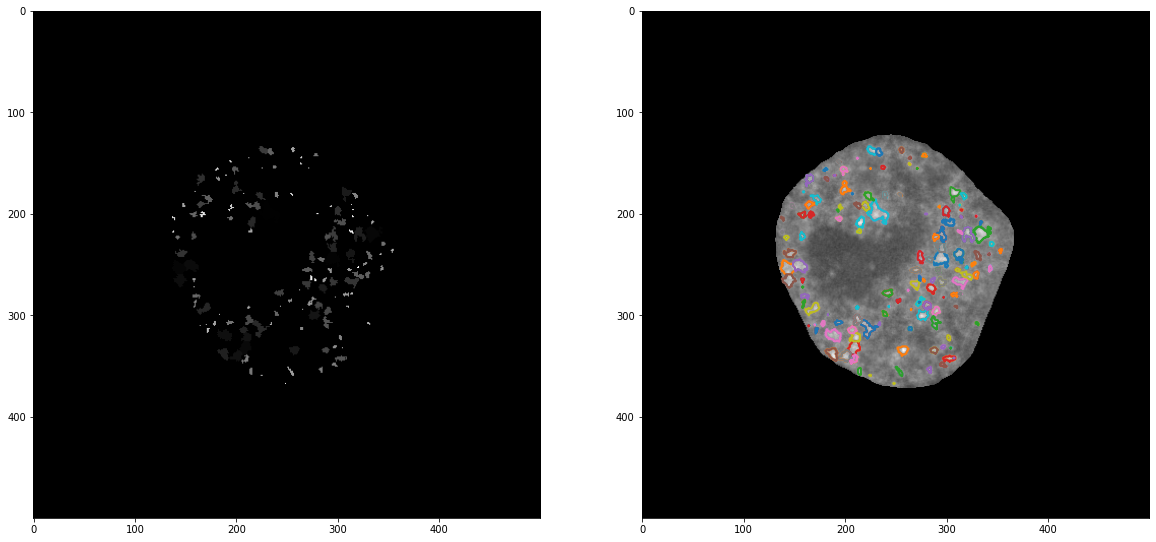

(83, 500, 500)
💠 CTRL-HPS9999-H3K27ac Calculate_quantitative_metrics:
chromatin_num: 84
nuclear_area: 45847
chromatin_area: 148.16666666666666
axis_ratio: 1.4798034952739125


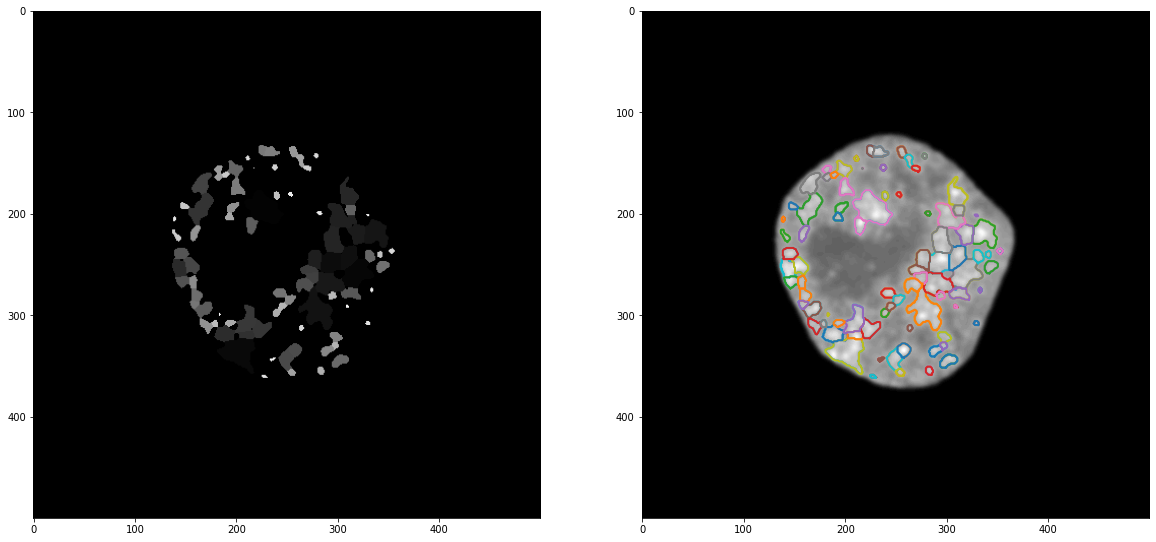

In [67]:
ctrl_type = "CTRL"
rett_type = "HPS9999"
chip_type = "H3K27ac"
home_path = "../Classification"

num = 1
cc_mask = show_mask_and_metrics(ctrl_type, rett_type, chip_type, num)
cc_masklr = show_mask_and_metrics(ctrl_type, rett_type, chip_type, num, lr=True)

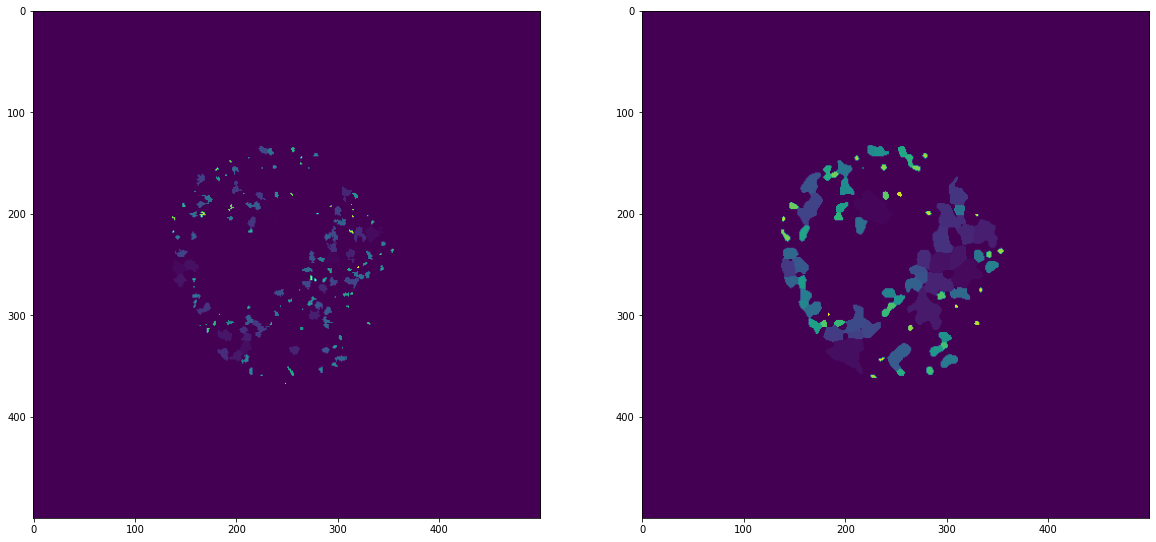

In [62]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(cc_mask)
plt.subplot(1,2,2)
plt.imshow(cc_masklr)

# Extract all chromatin particles

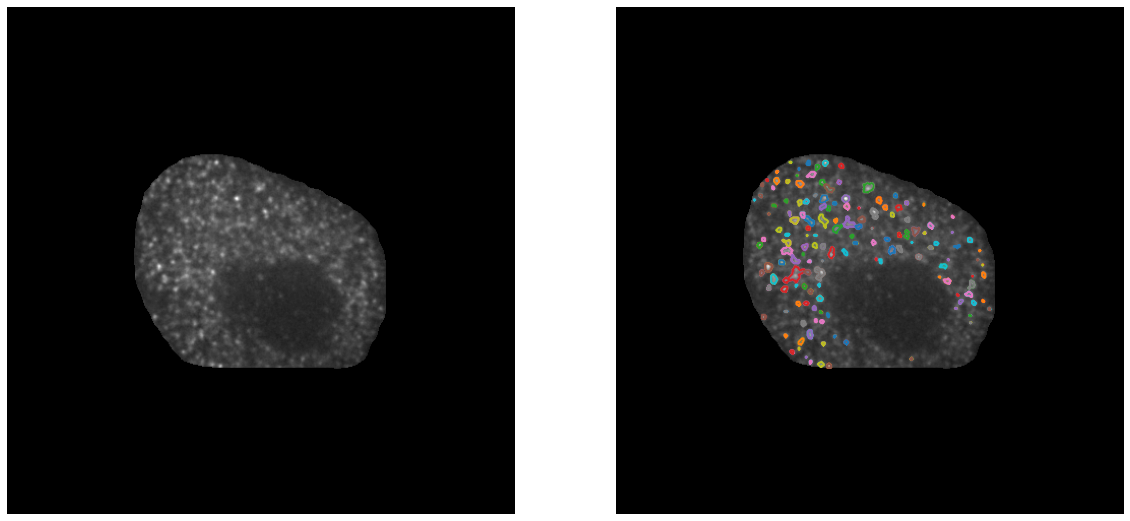

In [4]:
for im in range(1):
    image = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)[im,:,:,0]
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(image, cmap='gray')
    
    cc_mask = thre_h_watershed(image, ratio=1, max_area=None)
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.imshow(image, cmap='gray')
    plot_contours(image, cc_mask)
plt.show()

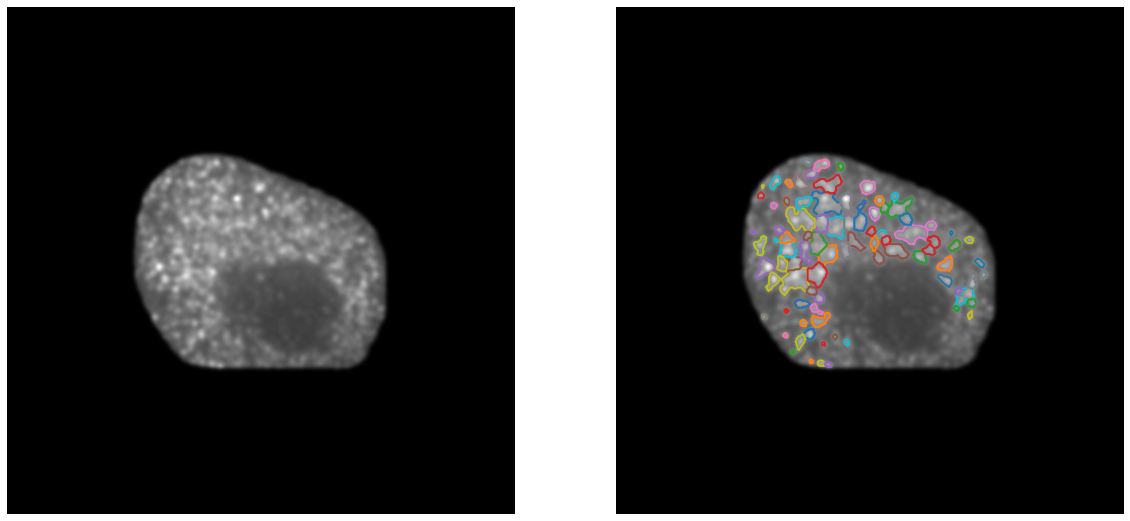

In [5]:
for im in range(1):
    image = np.load(f"{home_path}/Datasets_LR/{image_path}.npy", allow_pickle=True)[im,:,:,0]
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(image, cmap='gray')
    
    cc_mask = thre_h_watershed(image, ratio=1, max_area=None)
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.imshow(image, cmap='gray')
    plot_contours(image, cc_mask)
plt.show()

In [1]:
# home_path = "/groups/4/gaa50089/acd13264yb/Rettsyndrome/Classification"
# save_path = "/groups/4/gaa50089/acd13264yb/Rettsyndrome/Biomarker"
# for chip_type in ["H3K27ac", "CTCF"]:
#     ctrl_type = "RETT"
#     total_results = {}
#     for rett_type in ["HPS9999"]:
#         image_path = f"{ctrl_type}_{rett_type}_{chip_type}"
#         data = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)
#         print(f"load {image_path}")
#         results = []

#         for i in tqdm(range(len(data))):
#             image = data[i, :, :, 0]

#             cc_mask = thre_h_watershed(image, min_distance=5)
#             metrics = calculate_quantitative_metrics(image, cc_mask)
#             print(metrics)

#             # 将metrics字典转换为一行
#             result_row = {
#                 'chromatin_num': metrics['chromatin_num'],
#                 'nuclear_area': metrics['nuclear_area'],
#                 'chromatin_area': metrics['chromatin_area'],
#                 'RCA-S': metrics['RCA-S'],
#                 'RCA-M': metrics['RCA-M'],
#                 'nuclear_intensity': metrics['nuclear_intensity'],
#                 'chromatin_intensity': metrics['chromatin_intensity'],
#                 'RCI-S': metrics['RCI-S'],
#                 'RCI-M': metrics['RCI-M'],
#             }
#             results.append(result_row)

#         # 创建DataFrame
#         df = pd.DataFrame(results)
#         total_results[image_path] = df

#         # 保存DataFrame到文件
#         df.to_csv(f"{save_path}/tables/features_heterochromatin/{image_path}.csv", index=False)

        
        
#     ctrl_type = "CTRL"
#     image_path = f"{ctrl_type}_{chip_type}"
#     data = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)
#     print(f"load {image_path}")
#     results = []
#     for i in tqdm(range(len(data))):
#         image = data[i, :, :, 0]

#         cc_mask = thre_h_watershed(image, min_distance=5)
#         metrics = calculate_quantitative_metrics(image, cc_mask)

#         result_row = {
#             'chromatin_num': metrics['chromatin_num'],
#             'nuclear_area': metrics['nuclear_area'],
#             'chromatin_area': metrics['chromatin_area'],
#             'RCA-S': metrics['RCA-S'],
#             'RCA-M': metrics['RCA-M'],
#             'nuclear_intensity': metrics['nuclear_intensity'],
#             'chromatin_intensity': metrics['chromatin_intensity'],
#             'RCI-S': metrics['RCI-S'],
#             'RCI-M': metrics['RCI-M'],
#         }
#         results.append(result_row)
        
#     # 创建DataFrame
#     df = pd.DataFrame(results)
#     total_results[image_path] = df

#     # 保存DataFrame到文件
#     df.to_csv(f"{save_path}/tables/features_heterochromatin/{image_path}.csv", index=False)

In [43]:
# home_path = "/groups/4/gaa50089/acd13264yb/Rettsyndrome/Classification"
# save_path = "/groups/4/gaa50089/acd13264yb/Rettsyndrome/Biomarker"
# # chip_type = "H3K27ac"

# for chip_type in ["H3K27ac", "CTCF", "Dapi"]:
#     total_results = {}
#     for ctrl_type in ["RETT", "CTRL"]:
#         image_path = f"{ctrl_type}_{chip_type}"
#         cam = np.load(f"{home_path}/results_cam/{image_path}_Resnet10_noavg_ScoreCAM/{image_path}_Resnet10_noavg_ScoreCAM_cam.npy", allow_pickle=True)
#         print(f"{ctrl_type}_{chip_type} cam", cam.shape)
#         img = np.load(f"{home_path}/results_cam/{image_path}_Resnet10_noavg_ScoreCAM/{image_path}_Resnet10_noavg_ScoreCAM_img.npy", allow_pickle=True)
#         print(f"{ctrl_type}_{chip_type} img", img.shape)
#         if len(img)!=len(cam): 
#             print("len(img)!=len(cam) break")
#             break
            
#         results = []
#         for n in tqdm(range(len(img))):
#             image = img[n,:,:,0]
#             camm = cam[n,:,:]
#             camm = camm > threshold_otsu(camm)

#             max_eigenvalue = compute_largest_eigenvalue(image, sigma=1)
#             cc_mask = apply_h_watershed(max_eigenvalue, min_distance=5) * camm
#             metrics = calculate_quantitative_metrics(image, cc_mask)

#             # 将metrics字典转换为一行
#             result_row = {
#                 'number_of_cc': metrics['number_of_cc'],
#                 'nuclear_area': metrics['nuclear_area'],
#                 'heterochromatin_fraction': metrics['heterochromatin_fraction'],
#                 'relative_heterochromatin_intensity': metrics['relative_heterochromatin_intensity'],
#                 'relative_heterochromatin_fraction': metrics['relative_heterochromatin_fraction']
#             }

#             results.append(result_row)

#         # 创建DataFrame
#         df = pd.DataFrame(results)
#         total_results[image_path] = df

#         # 保存DataFrame到文件
#         df.to_csv(f"{save_path}/tables/features_chromatinCAM/{image_path}.csv", index=False)
